This notebook generates plots that display the monthly and cumulative purchasing of assets in DeGiro and the profit/loss compared to the current asset price.

The following nomenclature is used for ETFs and stocks
- Quantity: the amount of a particular asset
- Value: the value of an asset in a defined currency
- Total: Quantity * Value

A bond is purchased at the market price, which usually differs from the nominal value. The market price is often expressed as a percentage of the nominal value. For NEDER5,5%15JAN28 trades at 109% in February 2025, then buying 100 bonds at current market price will cost 100 * 1.09 = 109 EUR. Its face value / nominal value / par value is still 100 EUR and the interest rate is calculated over 100 EUR. Hence the quantity of the bonds dictates its value (but not the transaction).

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# load libraries
import pandas as pd
from src.functions import get_quantity_and_value_from_description
from src.functions import read_account_overview
from src.functions import get_historical_stock_price, get_total_value_purchased
from src.plots import plot_dividend, plot_transactions
from src.plots import plot_cumulative_transaction_value_and_current_value
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [53]:
# Load account xls into dataframe
df_account = read_account_overview('Account-2.xls')

# Define products explicitly (does not need to be the entire name)
products = ['VANGUARD', 'MATERIALS'] # ETF, Stock, Bond
tickers = ['VWRL.AS', 'MP']

Processing product: VANGUARD


/Users/jurnheinen/Python/degiro_analyser/src/plots.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(date, rotation=45, ha='right')


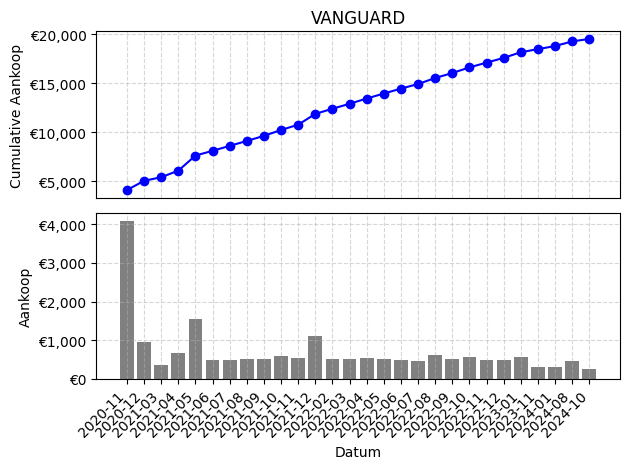

/Users/jurnheinen/Python/degiro_analyser/src/plots.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(date, rotation=45, ha='right')


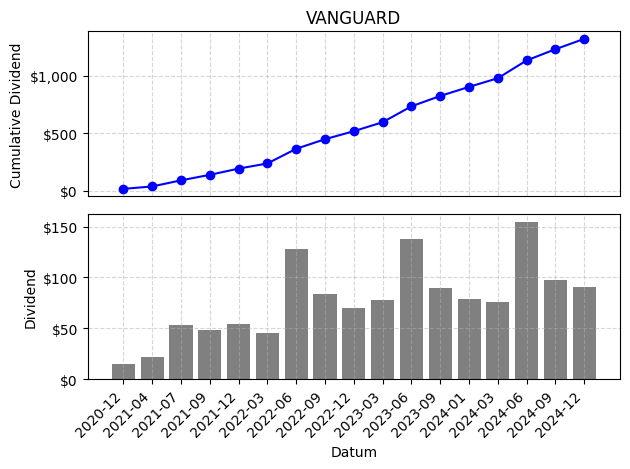

Processing product: MATERIALS


/Users/jurnheinen/Python/degiro_analyser/src/plots.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(date, rotation=45, ha='right')


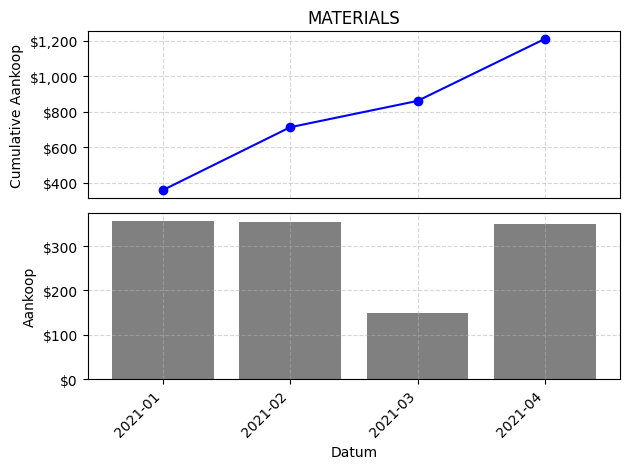

No dividend found for MATERIALS


In [ ]:
for product in products:
    print( f'Processing product: {product}' )
    # Get only records of pre-defined product
    df_product = df_account[df_account['Product'].str.contains(product)]

    # Selection of all transaction of product
    df_transactions = df_product[df_product['Omschrijving'].str.contains('Koop')].copy()

    # Get the currency of the account
    currency = df_transactions['Mutatie_Valuta'].values[0]
    
    # Get the quantity and value of each transaction
    df_transactions[['Transaction_Quantity', 'Transaction_Value']] = df_transactions['Omschrijving'].apply(lambda x: get_quantity_and_value_from_description(x)).tolist()

    # Calculate the total value of each transaction (quantity * value)
    df_transactions['Transaction_Total'] = df_transactions['Transaction_Quantity'] * df_transactions['Transaction_Value']

    df_transactions['Transaction_Total'] = df_transactions['Omschrijving'].apply(lambda x: get_total_value_purchased(x))

    # # Group all transactions by month and calculate the cumulative sum
    columns = ['Transaction_Quantity', 'Transaction_Value', 'Transaction_Total']
    df_transactions = df_transactions.groupby('datum_reduced', as_index=False)[columns].sum()

    # Calculate the cumulatice sum of the transaction quantity, total and value
    # Important: the Transaction_Total_Cum * Transaction_Quantity_Cum does NOT equals the Transaction_Value_Cum
    df_transactions['Transaction_Quantity_Cum'] = df_transactions['Transaction_Quantity'].cumsum(axis=0)
    df_transactions['Transaction_Total_Cum'] = df_transactions['Transaction_Total'].cumsum(axis=0)
    df_transactions['Transaction_Value_Cum'] = df_transactions['Transaction_Value'].cumsum(axis=0)
    
    plot_transactions(product,
                    df_transactions['datum_reduced'],
                    df_transactions['Transaction_Total'],
                    df_transactions['Transaction_Total_Cum'],
                    currency)

    # This is not the eactual received divident on the Flatex bank account.
    # One must subtract the DEGIRO Corporate Action Kosten as well as any foreign exchange conversion
    columns = ['Datum', 'Datum_Year', 'Mutatie_Valuta', 'Mutatie_Bedrag', 'Omschrijving']
    df_dividend = df_product[df_product['Omschrijving'].str.contains('Dividend')][columns]

    # Check if there are any dividends
    if df_dividend.empty:
        print(f'No dividend found for {product}')
        continue
    
    df_dividend.sort_values(by=['Datum'], inplace=True)
    df_dividend['Mutatie_Bedrag_Cum'] = df_dividend['Mutatie_Bedrag'].cumsum(axis=0)
    df_dividend['datum_reduced'] = df_dividend['Datum'].dt.strftime('%Y-%m')

    currency = df_dividend['Mutatie_Valuta'].values[0]
    plot_dividend(product,
                df_dividend['datum_reduced'],
                df_dividend['Mutatie_Bedrag'],
                df_dividend['Mutatie_Bedrag_Cum'],
                currency)
    
    df_dividend.groupby('Datum_Year')['Mutatie_Bedrag'].describe()

In [33]:
# Load first ticker
ticker = tickers[0]

# Define start and end date to get historical stock price
earliest_date = df_account['Datum'].min()
start_day = earliest_date.day
start_datetime = earliest_date.strftime('%Y-%m-%d')
current_datetime = datetime.now().strftime('%Y-%m-%d')

# If they ticker interval is set per month, the start date should be the first of the month
# If the start day is not equal to one, subtract one month from the earliest date to get
# the stock price at the first of the month
if start_day > 1:
    start_datetime = (earliest_date - timedelta(days=start_day)).strftime('%Y-%m-%d')

# Get historical stock price and reduce to monthly data
df_historical_price = get_historical_stock_price(ticker, start_datetime, current_datetime, '1mo')
df_historical_price['datum_reduced'] = df_historical_price.index.strftime('%Y-%m')

In [34]:
# Filter the stock price data to only include the dates of the transactions
filtered_df_ticker = df_historical_price[df_historical_price['datum_reduced'].isin(df_transactions['datum_reduced'])]

# Remove first row because we want to use the last day of the month (= first day of next month) as the stock price
filtered_df_ticker = filtered_df_ticker[1:]

# Subtract 2 days to make sure the stock price is available (in case the code is run on a weekend)
start_datetime_minus_2days = datetime.now() - timedelta(days=2)

# Get the last record of the dataframe as this corresponds to the most recent stock price
current_price = get_historical_stock_price(ticker, start_datetime_minus_2days, current_datetime, '1d').tail(1)

# Add the most recent stock price to the filtered dataframe
filtered_df_ticker = pd.concat([filtered_df_ticker, current_price])

/Users/jurnheinen/Python/degiro_analyser/src/plots.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(date, rotation=45, ha='right')


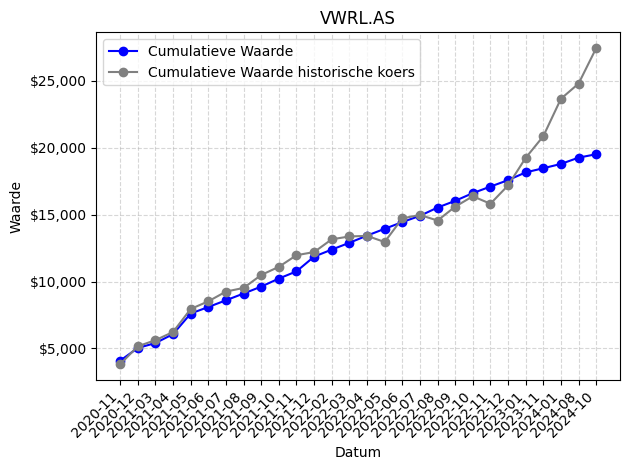

In [35]:
# Add historical prices to transactions for comparison
df_transactions['Historical_Value'] = filtered_df_ticker['Close'].values
df_transactions['Stock_Value_Cum'] = df_transactions['Transaction_Quantity_Cum'] * df_transactions['Historical_Value']

plot_cumulative_transaction_value_and_current_value(
    ticker,
    df_transactions['datum_reduced'],
    df_transactions['Transaction_Total_Cum'],
    df_transactions['Stock_Value_Cum'],
    currency)


In [8]:
#transactions.join(dividend.set_index('datum_reduced'), on='datum_reduced', how='left')
df_merge = pd.merge(df_transactions, dividend, on='datum_reduced', how='outer')
# sort on dateum_reduced
df_merge.sort_values(by=['datum_reduced'], inplace=True)
# replace all nan valuies by zero
df_merge.fillna(0, inplace=True)
# Replace all values of 0 by the previous value for the columns Transaction_Total_Cum and Stock_Value_Cum
df_merge['Transaction_Total_Cum'] = df_merge['Transaction_Total_Cum'].replace(0, method='ffill')
df_merge['Stock_Value_Cum'] = df_merge['Stock_Value_Cum'].replace(0, method='ffill')
df_merge['Mutatie_Bedrag_Cum'] = df_merge['Mutatie_Bedrag_Cum'].replace(0, method='ffill')


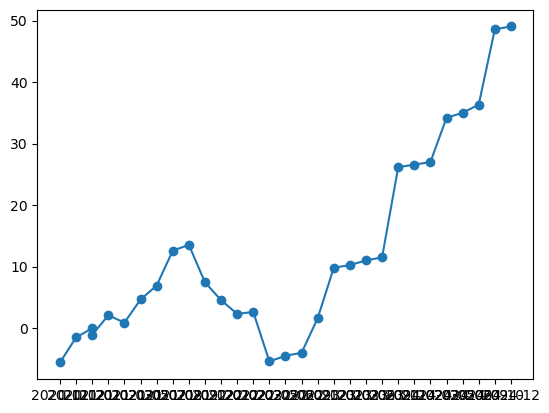

In [9]:
profit = (df_merge['Stock_Value_Cum'] - df_merge['Transaction_Total_Cum']) + df_merge['Mutatie_Bedrag_Cum']
profit_percentage = (profit / df_merge['Transaction_Total_Cum']) * 100

#plt.plot(df_merge['datum_reduced'], df_merge['Stock_Value_Cum'] - df_merge['Transaction_Total_Cum'])
#plt.plot(df_merge['datum_reduced'], df_merge['Mutatie_Bedrag_Cum'])
plt.plot(df_merge['datum_reduced'], profit_percentage, 'o-')


In [146]:
dividend['datum_reduced']

326    2020-12
281    2021-01
256    2021-01
237    2021-09
216    2021-12
198    2022-03
180    2022-06
164    2022-09
146    2022-12
132    2023-03
126    2023-06
120    2023-09
98     2024-02
68     2024-03
53     2024-06
34     2024-09
15     2024-12
Name: datum_reduced, dtype: object

In [19]:
stock = yf.Ticker("VWRL.AS")
df_stock = stock.history(start=start_datetime, end=current_datetime)